In [1]:
# !pip install pandas --upgrade  --quiet
# !pip install numpy --upgrade  --quiet
# !pip install scipy --upgrade  --quiet
# !pip install statsmodels --upgrade  --quiet
# !pip install scikit-learn --upgrade  --quiet
# !pip install missingno --upgrade  --quiet
!pip install apafib --upgrade --quiet

Objetivos de aprendizaje:
1. Identificar y aplicar el preproceso más adecuado a un conjunto de datos
2. Saber aplicar técnicas de reducción de dimensionalidad para la visualización de datos
3. Saber crear y aplicar clasificadores generativos y discriminativos
4. Interpretar los resultados de un problema de clasificación

# Problema 1: La economía va como un cohete
El centro de investigaciones sociológicas (CIS) es un organismo que tiene por finalidad el estudio científico de la sociedad y es una gran fuente de datos. Entre los diferentes estudios que realizan el índice de confianza del consumidor (ICC) se realiza mensualmente para obtener la opinión de los ciudadanos sobre su situación económica actual, sus perspectivas futuras y sobre ciertos temas de la economía del país. En este problema vamos a analizar una muestra de los resultados de esta encuesta durante año concreto intentando predecir una variable objetivo que se ha obtenido sobre los datos. La clave de las variables y su significado la puedes encontrar en la página web de los problemas. Puedes obtener este conjunto de datos mediante la función load_CIS_ICC de la librería apafib esta retornará un dataframe de Pandas. Resuelve los siguientes apartados ilustrando los resultados de la manera que te parezca más adecuada.

## Descripción de las variables
Antes de empezar a resolver el problema, vamos a ver el significado de las variables de este problema, ya que en el dataset no aparece su nombre, sino una clave.
 1. A.3   -> Sexo de la persona entrevistada
 2. A.4   -> Edad de la persona entrevistada
 3. B.2.2 -> Situación económica del hogar
 4. B.3.2 -> Valoración retrospectiva de la situación económica del hogar (6 meses)
 5. B.4   -> Número de personas en su entorno que se hallan en paro y buscando trabajo en la actualidad
 6. B.6   -> Valoración retrospectiva de la posibilidad de mejorar o encontrar empleo en España (6 meses)
 7. B.7   -> Valoración retrospectiva de la situación económica de España (6 meses)
 8. C.1   -> Valoración prospectiva de la posibilidad de mejorar o encontrar empleo en España (6 meses)
 9. C.2   -> Valoración prospectiva de la probabilidad de adquirir para el hogar bienes duraderos (1 año)
10. C.3   -> Evolución de la capacidad de ahorro personal (1 año)
11. C.4.2 -> Valoración prospectiva de la situación económica del hogar (6 meses)
12. C.5   -> Valoración prospectiva de la situación económica de España (6 meses)
13. D.1   -> Valoración prospectiva de la inflación en España (1 año)
14. D.2.2 -> Evolución de los tipos de interés en España (1 año) (II)
15. D.3.2 -> Evolución del precio de la vivienda en España (1 año) (II)
16. D.4   -> Intención de comprar una vivienda en el próximo año
17. F.1   -> Escala de autoubicación ideológica (1-10)
18. G.1   -> Estado civil de la persona entrevistada
19. G.2   -> Tamaño del hogar
20. G.4.2 -> Número de personas en el hogar con ingresos (desde noviembre de 2020)
21. G.6.2 -> Nivel de ingresos del hogar (II)
22. G.7   -> Situación laboral de la persona entrevistada
23. G.8   -> Régimen de tenencia de la vivienda de la persona entrevistada
24. Target

A continuación, cargamos los datos, y realizamos una mínima exploración para ver las dimensiones de estos, así como los missing values y la distribución de la variable objetivo. Vemos que todas las variables son categóricas menos dos (edad y escala de autoubicación ideológica).

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay
from yellowbrick.classifier.rocauc import roc_auc
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from apafib import load_CIS_ICC

ICC = load_CIS_ICC()
print(f"Dimensiones: {ICC.shape}")
print(f"\nTipos de variables:")
print(ICC.dtypes.value_counts())
print(f"\nMissing values de cada columna:")
print(ICC.isnull().sum())
print(f"\nDistribución de la variable objetivo:")
print(ICC["Target"].value_counts())
print(f"\nCabecera del dataset:")
ICC.head()

Dimensiones: (2500, 24)

Tipos de variables:
category    5
category    2
float64     2
category    2
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
int32       1
Name: count, dtype: int64

Missing values de cada columna:
A.3         0
A.4         0
B.2.2      20
B.3.2      15
B.4        37
B.6       257
B.7        71
C.1       194
C.2        44
C.3        41
C.4.2      58
C.5       106
D.1        83
D.2.2     198
D.3.2      60
D.4        15
F.1       231
G.1         5
G.2         1
G.4.2       4
G.6.2      85
G.7         0
G.8        10
Target      0
dtype: int64

Distribución de la variable objetivo:
Target
2    746
1    563
0    434
4    388
3    369
Name: count, dtype: int64

Cabecera del dataset:


,A.3,A.4,B.2.2,B.3.2,B.4,B.6,B.7,C.1,C.2,C.3,...,D.3.2,D.4,F.1,G.1,G.2,G.4.2,G.6.2,G.7,G.8,Target
2055,Mujer,37.0,Ahorra bastante dinero cada mes,Igual (NO LEER),Ninguna,Peor,Peor,Peor,Menores,Menores,...,Se mantendrá,No,1.0,Soltero/a,2 personas,2 personas,De 1.801 a 2.700 &euro;,Trabaja,En propiedad por compra y está totalmente pagada,1
1961,Mujer,71.0,Ahorra un poco de dinero cada mes,Peor,Ninguna,Mejor,Peor,Peor,Iguales,Iguales,...,Se mantendrá,No,6.0,Separado/a,Vive solo/a,Ninguna,De 1.801 a 2.700 &euro;,Jubilado/a o pensionista (ha trabajado),En propiedad por compra y está totalmente pagada,4
1864,Hombre,45.0,Llega justo a final de mes,Igual (NO LEER),Ninguna,Mejor,Mejor,Mejor,Iguales,Iguales,...,Subirá,No,3.0,Casado/a,4 personas,2 personas,Más de 3.900 &euro;,Trabaja,En propiedad por compra y con pagos o hipoteca...,2
2326,Hombre,53.0,Ahorra un poco de dinero cada mes,Igual (NO LEER),Ninguna,NaN,Igual (NO LEER),Igual (NO LEER),Mayores,Mayores,...,Subirá,No,4.0,Casado/a,2 personas,3 personas,De 1.801 a 2.700 &euro;,Trabaja,En propiedad por compra y con pagos o hipoteca...,2
461,Mujer,53.0,Ahorra un poco de dinero cada mes,Mejor,2 personas,Igual (NO LEER),Igual (NO LEER),Mejor,Iguales,Iguales,...,Se mantendrá,No,5.0,Casado/a,3 personas,2 personas,Más de 3.900 &euro;,Trabaja,En propiedad por compra y con pagos o hipoteca...,0


In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

## a)
### Divide el conjunto de datos en entrenamiento y test (80 %/20 %).
En problemas de clasificación, es crucial que los conjuntos de entrenamiento y test tengan la misma distribución de clases que el dataset original. Si una clase está sobrerrepresentada en test, el modelo parecerá mejor de lo que es mientras que si una clase está infrarrepresentada, no podremos evaluar bien su clasificación. Por lo tanto, a la hora de hacer la division de datos en los conjuntos de entrenamiento y test, debemos hacer una división estratificada.

In [4]:
X = ICC.iloc[:, :-1] # Columnas 1-23
Y = ICC.iloc[:, -1] # Columna 24 (Target)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22, stratify = Y)

print("División estratificada del conjunto de datos en entrenamento y test (80/20)%")
print("-"*92)
print(f"Dimensiones de train: {X_train.shape}. Dimensiones de test: {X_test.shape}")
print(f"Distribución en train (proporcuón): {Y_train.value_counts()/sum(Y_train.value_counts())}")
print(f"Distribución en test (proporcuón): {Y_test.value_counts()/sum(Y_test.value_counts())}")

División estratificada del conjunto de datos en entrenamento y test (80/20)%
--------------------------------------------------------------------------------------------
Dimensiones de train: (2000, 23). Dimensiones de test: (500, 23)
Distribución en train (proporcuón): Target
2    0.2985
1    0.2255
0    0.1735
4    0.1550
3    0.1475
Name: count, dtype: float64
Distribución en test (proporcuón): Target
2    0.298
1    0.224
0    0.174
4    0.156
3    0.148
Name: count, dtype: float64


Podemos ver que las proporciones de las clases es la misma en ambos conjuntos (train y test), así que hemos realizado la división estratificiada correctamente.

### Comprobarás que la mayoría de las variables del conjunto de datos son categóricas. Tienes variables categóricas que son ordenadas y variables categóricas que no lo son. Tendrás que convertir adecuadamente cada una de estas variables en variables numéricas. Fíjate que encontrarás que hay bastantes valores perdidos, los imputaremos de manera diferente dependiendo de si provienen de variables categóricas no ordenadas o del resto de tipos (continuas/categóricas ordenadas). Primero, para las categóricas, la función de Pandas que calcula las columnas de la codificación One Hot permite indicar que se quiere una columna más para el valor perdido, lo haremos así. Después imputa los valores perdidos de las variables continuas y categóricas ordenadas usando el KNNImputer.
Primero de todo vamos a clasificar (justificando la clasificación) nuestras variables en tres grupos: variables categóricas ordenadas, variables categóricas no ordenadas y variables numéricas. Una vez realizada la clasificación imputaremos los valores perdidos de cada clase con su método adecuado y convertiremos todas las variables a numéricas.
Para realizar la clasificación de las variables en los grupos descritos, al descargado la descripción de las variables desde la página web de CIS y obtener sus nombres (que hemos visto anteriormente), hemos obtenido también todos los posibles valores que puede tomar cada variable. A partir de ahí hemos dividido las variables en las categorías descritas, mirando también los valores que aparecen en el dataset (no aparecen todos los posibles valores de todas las variables). 
- Variables categóricas ordenadas. Son aquellas en que hay un orden claro en cuanto a sus posibles valores; vemos a continuación las variables de esta categoria con sus valores ordenados:
    - B.2.2 - Situación económica del hogar
      1. Le resulta difícil llegar a final de mes, por lo que han ten (en teoría hay dos posibles valores distintos que empiezan igual, pero son demasiado largos, y al coger los primeros 60 caracteres en el dataset de apafib se han fusionado en un solo valor)
      2. Llega justo a final de mes
      3. Ahorra un poco de dinero cada mes
      4. Ahorra bastante dinero cada mes
    - B.3.2 - Valoración retrospectiva de la situación económica del hogar (6 meses)
      1. Peor
      2. Igual (NO LEER)
      3. Mejor
    - B.4 - Número de personas en su entorno que se hallan en paro y buscando trabajo en la actualidad
      1. Ninguna
      2. 1 persona
      3. 2 personas
      4. 3 personas
      5. 4 personas
      6. Mas personas
    - B.6 - Valoración retrospectiva de la posibilidad de mejorar o encontrar empleo en España (6 meses)
      1. Peor
      2. Igual (NO LEER)
      3. Mejor
    - B.7 - Valoración retrospectiva de la situación económica de España (6 meses)
      1. Peor
      2. Igual (NO LEER)
      3. Mejor
    - C.1 - Valoración prospectiva de la posibilidad de mejorar o encontrar empleo en España (6 meses)
      1. Peor
      2. Igual (NO LEER)
      3. Mejor
    - C.2 - Valoración prospectiva de la probabilidad de adquirir para el hogar bienes duraderos (1 año)
      1. Menores
      2. Iguales
      3. Mayores
    - C.3 - Evolución de la capacidad de ahorro personal (1 año)
      1. Menores
      2. Iguales
      3. Mayores
    - C.4.2 - Valoración prospectiva de la situación económica del hogar (6 meses)
      1. Peor
      2. Igual (NO LEER)
      3. Mejor
    - C.5 - Valoración prospectiva de la situación económica de España (6 meses)
      1. Peor
      2. Igual (NO LEER)
      3. Mejor
    - D.1 - Valoración prospectiva de la inflación en España (1 año)
      1. Menos
      2. Igual
      3. Más
    - D.2.2 - Evolución de los tipos de interés en España (1 año) (II)
      1. Bajará
      2. Se mantendrá
      3. Subirá
    - D.3.2 - Evolución del precio de la vivienda en España (1 año) (II)
      1. Bajará
      2. Se mantendrá
      3. Subirá
    - G.2 - Tamaño del hogar
      1. Vive solo/a
      2. 1 persona
      3. 2 personas
      4. 3 personas
      5. 4 personas
      6. Mas personas
    - G.4.2 - Número de personas en el hogar con ingresos (desde noviembre de 2020)
      1. Ninguna
      2. 1 persona
      3. 2 personas
      4. 3 personas
      5. 4 personas
      6. 5 personas
    - G.6.2 - Nivel de ingresos del hogar (II)
      1. Menos de 1.100 &euro;
      2. De 1.100 a 1.800 &euro;
      3. De 1.801 a 2.700 &euro;
      4. De 2.701 a 3.900 &euro;
      5. Más de 3.900 &euro;

- Variables categóricas no ordenadas. Son aquellas en que no hay un orden claro en cuanto a sus posibles valores (las binarias las hemos considerado como categóricas no ordenadas); vemos a continuación las variables de esta categoria con sus valores:
    - A.3 - Sexo de la persona entrevistada
      * Hombre
      * Mujer
    - D.4 - Intención de comprar una vivienda en el próximo año
      * Sí
      * No
    - G.1 - Estado civil de la persona entrevistada
      * Casado/a
      * Divorciado/a
      * Separado/a
      * Soltero/a
      * Viduo/a
    - G.7 - Situación laboral de la persona entrevistada
      * Estudiante
      * Jubilado/a o pensionista (ha trabajado)
      * Otra situación
      * Parado/a y busca su primer empleo
      * Parado/a y ha trabajado antes
      * Pensionista (no ha trabajado
      * Trabaja
      * Trabajo doméstico no remunerado
    - G.8 - Régimen de tenencia de la vivienda de la persona entrevistada
      * Cedida gratis o a bajo precio por un/a familiar, la empresa, (valor demasiado largo, en el dataset de apafib se han cogido los primeros 60 caracteres)
      * En alquiler
      * En propiedad por compra y con pagos o hipotecas pendientes
      * En propiedad por compra y está totalmente pagada
      * En propiedad por herencia o donación
      * Otra forma

- Variables numéricas. Vemos a continuación las variables de esta categoría con su rango de valores discretos:
    - A.4 - Edad de la persona entrevistada [16, 95]
    - F.1 - Escala de autoubicación ideológica [1, 10]

Para ver todos los valores de cada variable hemos hecho lo siguiente para cada columna de ICC: print(ICC[c].unique())

De esta forma, además vemos que solo hay un tipo de valores perdidos: NaN. Por lo tanto, no tenemos que manejar valores especiales/perdidos (unificarlos para que todos sean NaN en vez de tener NaNs y "" como valores perdidos por ejemplo) ya que solo hay un tipo.

Ahora, procedemos a convertir las variables categóricas no ordenadas a numéricas usando One Hot Encoding con una columna separada para los missing values, y convertimos las variables categóricas ordenadas a numéricas usando KNN para imputar los valores perdidos. Usamos KNN también para imputar los missing values de las variables numéricas.

In [5]:
cat_ordenadas = ["B.2.2", "B.3.2", "B.4", "B.6", "B.7", "C.1", "C.2", "C.3", "C.4.2", "C.5", "D.1", "D.2.2", "D.3.2", "G.2", "G.4.2", "G.6.2"]
cat_no_ordenadas = ["A.3", "D.4", "G.1", "G.7", "G.8"]
numericas = ["A.4", "F.1"]

# One Hot Encoding para las variables categóricas no ordenadas
for col in cat_no_ordenadas:
    # conjunto train
    dummies = pd.get_dummies(X_train[col], drop_first = True, prefix = col, prefix_sep = '_', dummy_na = True)
    X_train = pd.concat([X_train, dummies], axis = 1)
    X_train.drop(columns = [col], inplace = True)

    # conjunto test
    dummies = pd.get_dummies(X_test[col], drop_first = True, prefix = col, prefix_sep = '_', dummy_na = True)
    X_test = pd.concat([X_test, dummies], axis = 1)
    X_test.drop(columns = [col], inplace = True)

# Convertimos a numérico las variables categóricas ordenadas
# Usamos mapping para mantener orden semántico
mapping = {
    "B.2.2": {"Le resulta difícil llegar a final de mes, por lo que han ten": 0, "Llega justo a final de mes": 1, "Ahorra un poco de dinero cada mes": 2, "Ahorra bastante dinero cada mes": 3},
    "B.3.2": {"Peor": 0, "Igual (NO LEER)": 1, "Mejor": 2},
    "B.4": {"Ninguna": 0, "1 persona": 1, "2 personas": 2, "3 personas": 3, "4 personas": 4, "Mas personas": 5},
    "B.6": {"Peor": 0, "Igual (NO LEER)": 1, "Mejor": 2},
    "B.7": {"Peor": 0, "Igual (NO LEER)": 1, "Mejor": 2},
    "C.1": {"Peor": 0, "Igual (NO LEER)": 1, "Mejor": 2},
    "C.2": {"Menores": 0, "Iguales": 1, "Mayores": 2},
    "C.3": {"Menores": 0, "Iguales": 1, "Mayores": 2},
    "C.4.2": {"Peor": 0, "Igual (NO LEER)": 1, "Mejor": 2},
    "C.5": {"Peor": 0, "Igual (NO LEER)": 1, "Mejor": 2},
    "D.1": {"Menos": 0, "Igual": 1, "Más": 2},
    "D.2.2": {"Bajará": 0, "Se mantendrá": 1, "Subirá": 2},
    "D.3.2": {"Bajará": 0, "Se mantendrá": 1, "Subirá": 2},
    "G.2": {"Vive solo/a": 0, "1 persona": 1, "2 personas": 2, "3 personas": 3, "4 personas": 4, "Mas personas": 5},
    "G.4.2": {"Ninguna": 0, "1 persona": 1, "2 personas": 2, "3 personas": 3, "4 personas": 4, "5 personas": 5},
    "G.6.2": {"Menos de 1.100 &euro;": 0, "De 1.100 a 1.800 &euro;": 1, "De 1.801 a 2.700 &euro;": 2, "De 2.701 a 3.900 &euro;": 3, "Más de 3.900 &euro;": 4}
}
for col in cat_ordenadas:
    # conjunto train
    X_train[col] = X_train[col].map(mapping[col])

    # conjunto test
    X_test[col] = X_test[col].map(mapping[col])

# Imputamos con KNN los valores perdidos restantes
# Usamos todas las variables (también las One Hot) ya que solo hay missing values en las numéricas y categóricas ordenadas (numerizadas)
knni = KNNImputer(n_neighbors = 5)
X_train = pd.DataFrame(knni.fit_transform(X_train), columns = X_train.columns.tolist(), index = X_train.index)
X_test = pd.DataFrame(knni.transform(X_test), columns = X_test.columns.tolist(), index = X_test.index)

# Comprobamos que no hay missing values en train ni test
print("Missing values en train: ", X_train.isnull().sum().sum())
print("Missing values en test: ", X_test.isnull().sum().sum())

Missing values en train:  0
Missing values en test:  0


Podemos ver que ya no queda ningún valor perdido.

### Una vez tenemos el conjunto de datos preprocesado puedes aplicar adecuadamente PCA para ver su comportamiento. Analiza sus resultados y representa la variable objetivo sobre el PCA en dos dimensiones. Explica lo que has observado.
PCA se basa en la matriz de covarianza de las variables, asume que los datos estan estandarizados, asi que aplicaremos esa transformación. Esto cambiará los datos para que todas las variables tengan media 0 y desviación estándar 1.

[1.16286841e-01 8.92952440e-02 6.13984555e-02 4.26055335e-02
 3.86024291e-02 3.76626274e-02 3.29022018e-02 3.20740703e-02
 3.09749219e-02 3.03141405e-02 2.90546973e-02 2.83807801e-02
 2.72978056e-02 2.62046566e-02 2.60021291e-02 2.55175710e-02
 2.45180341e-02 2.37288005e-02 2.27582542e-02 2.19200443e-02
 2.17320485e-02 2.11110346e-02 2.03470912e-02 1.87358952e-02
 1.79568356e-02 1.62383181e-02 1.57856484e-02 1.43767144e-02
 1.38471848e-02 1.15084172e-02 1.14253881e-02 9.51721759e-03
 8.80692375e-03 8.38117702e-03 8.09488393e-03 6.51317457e-03
 5.69661730e-03 1.24727298e-03 1.17891905e-03 7.81146994e-19
 0.00000000e+00]
[0.11628684 0.20558208 0.26698054 0.30958607 0.3481885  0.38585113
 0.41875333 0.4508274  0.48180232 0.51211646 0.54117116 0.56955194
 0.59684975 0.6230544  0.64905653 0.6745741  0.69909214 0.72282094
 0.74557919 0.76749924 0.78923129 0.81034232 0.83068941 0.84942531
 0.86738214 0.88362046 0.89940611 0.91378282 0.92763001 0.93913843
 0.95056381 0.96008103 0.96888796 0.97

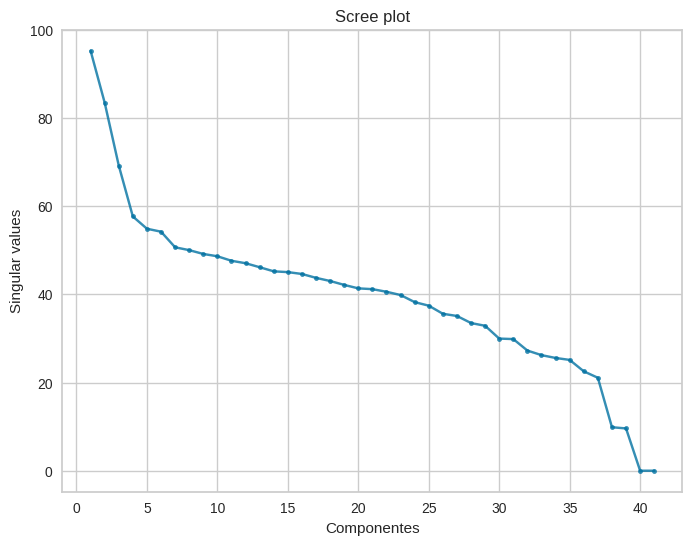

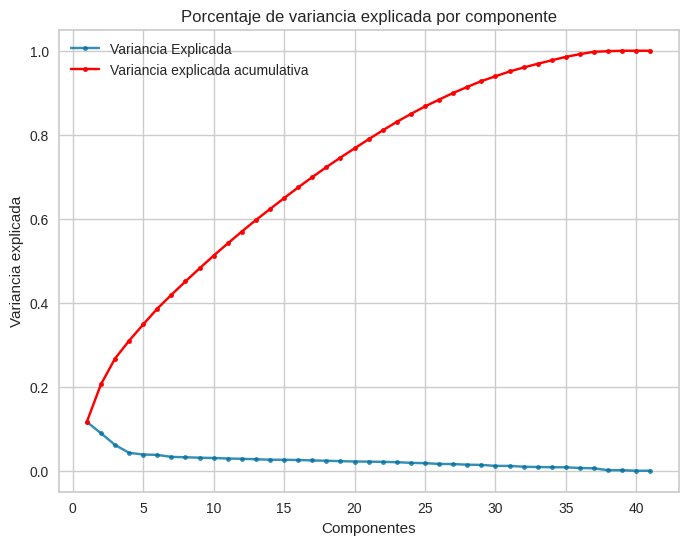

In [6]:
X_train_std = X_train.copy()
X_train_std[X_train_std.columns.tolist()] = StandardScaler().fit_transform(X_train_std[X_train_std.columns.tolist()])

myPCA = PCA().fit(X_train_std);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

fig = plt.figure(figsize = (8, 6));
plt.plot(range(1, len(myPCA.singular_values_) + 1), myPCA.singular_values_, alpha = 0.8, marker = '.');
y_label = plt.ylabel('Singular values');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

fig = plt.figure(figsize = (8, 6));
plt.plot(range(1, len(myPCA.explained_variance_ratio_) + 1), myPCA.explained_variance_ratio_, alpha = 0.8, marker = '.', label = "Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1, len(myPCA.explained_variance_ratio_) + 1), np.cumsum(myPCA.explained_variance_ratio_), c = 'red', marker = '.', label = "Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Podemos ver que las variables son bastante homogéneas en cuanto a la cantidad de información que representan en el PCA (la que más varianza explica explica menos del 20%). Por lo tanto, vemos que para mantener un 80% de la varianza total necesitamos 21 componentes, así que no podremos ver los datos muy bien representados en 2D.

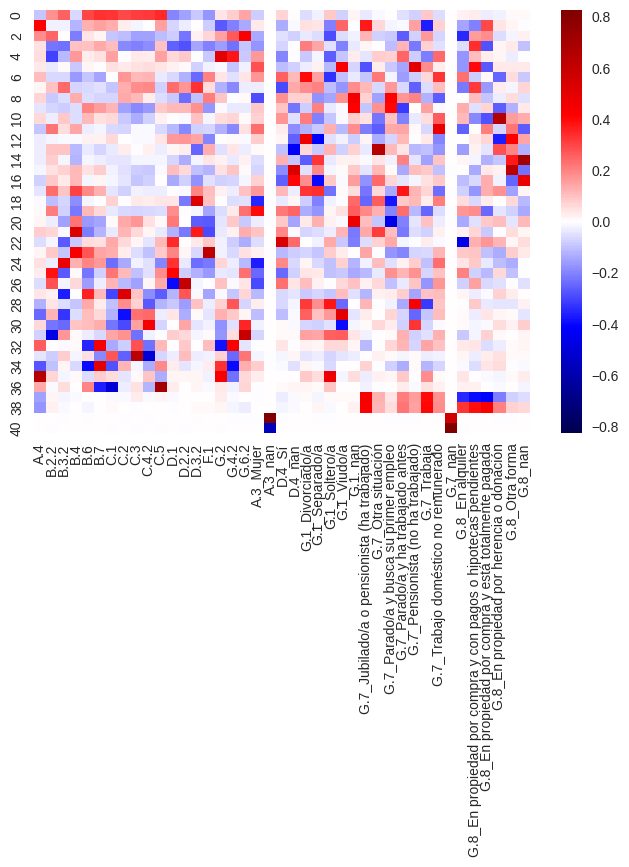

In [7]:
sns.heatmap(myPCA.components_, cmap = 'seismic', xticklabels = list(X_train.columns[:]), vmin = -np.max(np.abs(myPCA.components_)), vmax = np.max(np.abs(myPCA.components_)), annot = False);

Vemos arriba que variables contribuyen más a cada una de las componentes obtenidas con PCA. Como hemos dicho antes, vemos que su contribución es bastante homogenea (todas contribuyen similarmente) y reducida.

<Axes: xlabel='PC1', ylabel='PC2'>

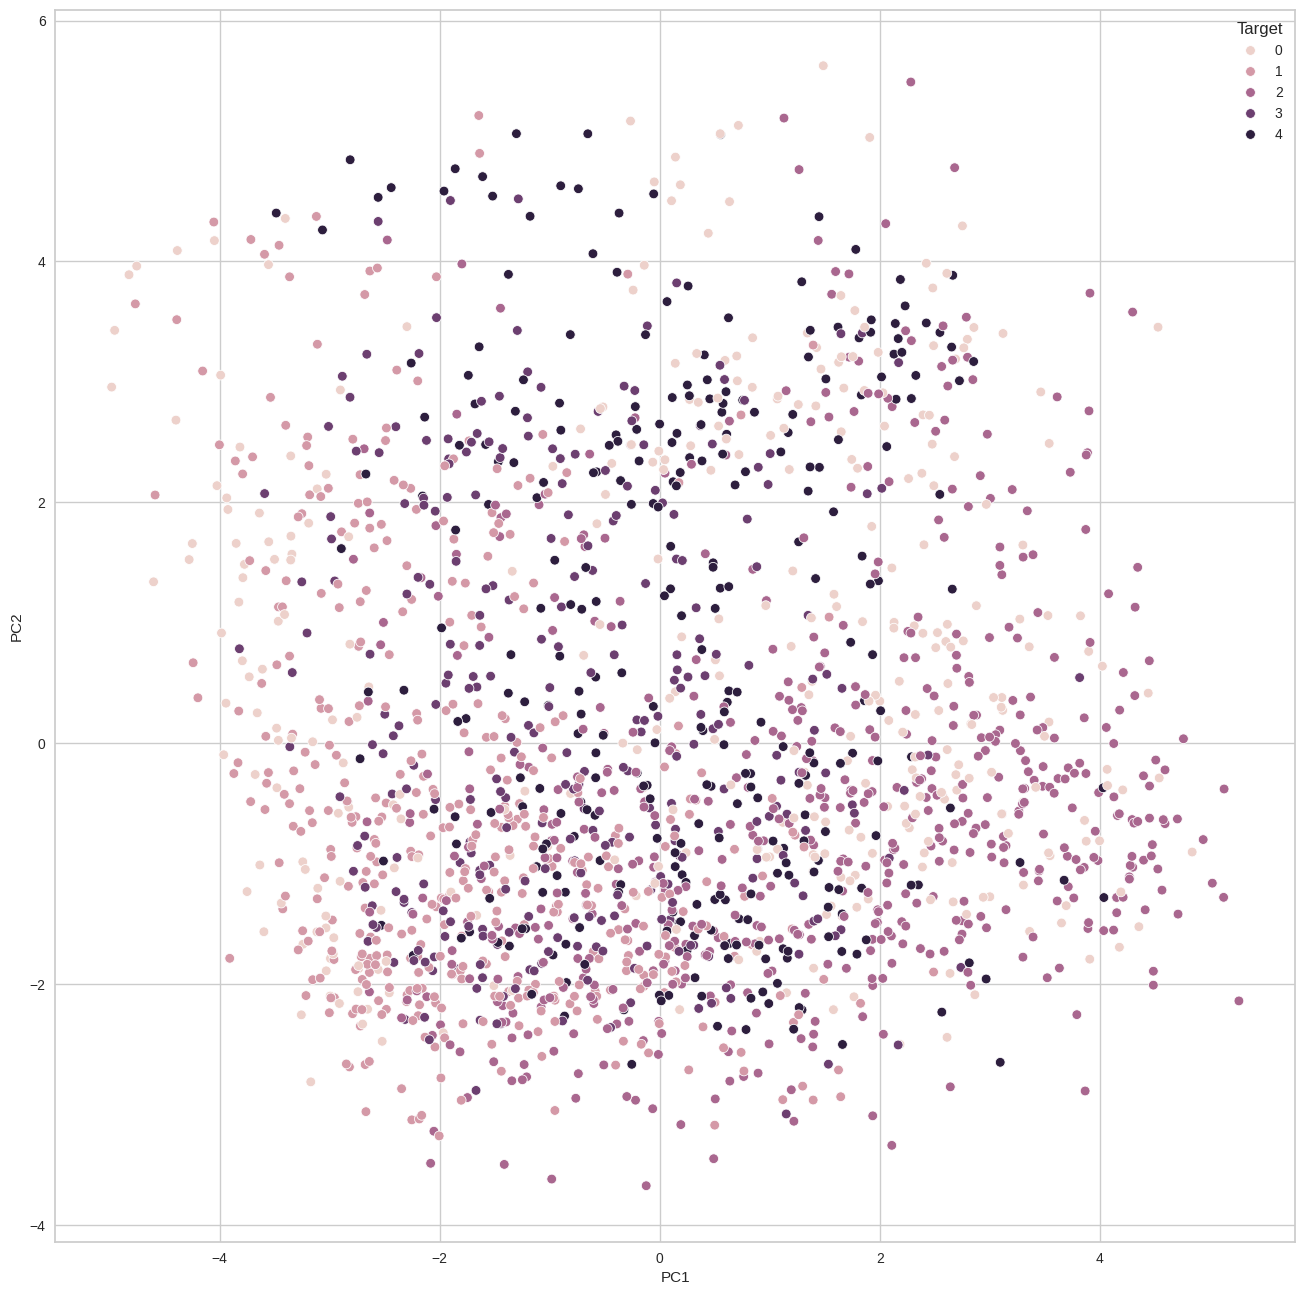

In [8]:
trans_X_train = myPCA.transform(X_train_std[X_train_std.columns.tolist()])
pca_2d = pd.DataFrame(trans_X_train[:, :2], columns = ['PC1', 'PC2'])
pca_2d['Target'] = Y_train.values
fig = plt.figure(figsize = (16, 16))
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Target', data = pca_2d)

A primera vista, no parece que se puedan distinguir las diferentes clases de la variable objetivo, ya que estas estan bastante superpuestas, mezcladas y dispersas en el PCA 2D como podemos ver arriba. Sin embargo, esto no significa que las clases no sean separables, ya que como hemos dicho anteriormente con 2 componentes del PCA obtenemos muy poca información sobre nuestros datos ya que PC1 y PC2 solo explican un poco más del 20% de la varianza total de nuestros datos; estamos perdiendo mucha información al graficar el PCA en 2D. Así pues, esta visualización del PCA no nos aporta mucha información y por lo tanto no podemos sacar conclusiones válidas de ella.

In [9]:
# Análisis de separabilidad
# Calcular algunos estadísticos básicos por clase
for class_label in np.unique(Y_train):
    class_data = pca_2d[pca_2d['Target'] == class_label]
    print(f"Clase {class_label}:")
    print(f"  - Número de muestras: {len(class_data)}")
    print(f"  - Centroide PC1: {class_data['PC1'].mean():.3f}")
    print(f"  - Centroide PC2: {class_data['PC2'].mean():.3f}")
    print(f"  - Dispersión PC1: {class_data['PC1'].std():.3f}")
    print(f"  - Dispersión PC2: {class_data['PC2'].std():.3f}")
    print()

var_pca = (myPCA.explained_variance_ratio_[0] + myPCA.explained_variance_ratio_[1])*100
print("Varianza explicada por el PCA: ", var_pca, "%")

Clase 0:
  - Número de muestras: 347
  - Centroide PC1: 0.350
  - Centroide PC2: 0.684
  - Dispersión PC1: 2.534
  - Dispersión PC2: 1.908

Clase 1:
  - Número de muestras: 451
  - Centroide PC1: -1.713
  - Centroide PC2: -0.568
  - Dispersión PC1: 1.322
  - Dispersión PC2: 1.715

Clase 2:
  - Número de muestras: 597
  - Centroide PC1: 1.348
  - Centroide PC2: -0.442
  - Dispersión PC1: 1.938
  - Dispersión PC2: 1.625

Clase 3:
  - Número de muestras: 295
  - Centroide PC1: -0.777
  - Centroide PC2: 0.164
  - Dispersión PC1: 1.385
  - Dispersión PC2: 1.707

Clase 4:
  - Número de muestras: 310
  - Centroide PC1: 0.245
  - Centroide PC2: 0.756
  - Dispersión PC1: 1.407
  - Dispersión PC2: 2.083

Varianza explicada por el PCA:  20.558208478796455 %


Podemos ver de forma numérica lo que hemos estado diciendo antes: las clases de la variable objetivo estan bastante superpuestas, mezcladas y dispersas en el PCA 2D. Vemos también que esto no significa que las clases no sean separables ya que no podemos sacar conclusiones válidas de esta visualización de los datos debido a que con 2 componentes del PCA obtenemos muy poca información sobre nuestros datos ya que PC1 y PC2 solo explican un poco más del 20% de la varianza total de nuestros datos; estamos perdiendo mucha información al graficar el PCA en 2D. Por esta misma razón, no vamos a analizar que variables contribuyen más a los componentes seleccionados del PCA ni el significado de estos.

## b)
### Empezaremos aplicando un modelo discriminante lineal (LDA) para comprobar la separabilidad de las clases. Evalúa adecuadamente la calidad del modelo. Representa los pesos del modelo como un mapa de calor ¿Qué puedes comentar sobre la importancia de las variables?

In [28]:
scaler = StandardScaler()
X_train_std = X_train.copy()
X_train_std[X_train_std.columns.tolist()] = scaler.fit_transform(X_train_std[X_train_std.columns.tolist()])
X_test_std = X_test.copy()
X_test_std[X_test_std.columns.tolist()] = scaler.transform(X_test_std[X_test_std.columns.tolist()])

lda_model = LinearDiscriminantAnalysis()
lda_model.best_score_ = np.mean(cross_val_score(lda_model, X_train_std, Y_train, cv=10))
print(f"CV Score: {lda_model.best_score_}")

CV Score: 0.6729999999999999


El LDA tiene una validación cruzada de 67.29%, lo que no es muy alto. LDA assumeix que todas las clases comparten la misma matriz de covarianza, pero viendo el resultado obtenido, lo más seguro es que con nuestros datos esta suposición no se cumpla. Volviendo a la información obtenida con PCA (aunque esta no sea muy fiable ya que el PCA solo explicaba un 20% de la varianza de los datos) ya veíamos que las clases tienen diferente dispersión.

In [29]:
lda_model = LinearDiscriminantAnalysis().fit(X_train_std, Y_train)

print('Priors:', lda_model.priors_)
print('Medias por clase:\n')
means = pd.DataFrame(lda_model.means_)
means.columns = X_train.columns
means

Priors: [0.1735 0.2255 0.2985 0.1475 0.155 ]
Medias por clase:



,A.4,B.2.2,B.3.2,B.4,B.6,B.7,C.1,C.2,C.3,C.4.2,...,G.7_Pensionista (no ha trabajado),G.7_Trabaja,G.7_Trabajo doméstico no remunerado,G.7_nan,G.8_En alquiler,G.8_En propiedad por compra y con pagos o hipotecas pendientes,G.8_En propiedad por compra y está totalmente pagada,G.8_En propiedad por herencia o donación,G.8_Otra forma,G.8_nan
0,0.196491,0.004983,-0.040323,0.001358,0.413235,0.488237,0.340109,-0.090881,-0.001338,-0.068609,...,0.070325,-0.177349,0.178025,0.0,-0.075197,-0.057421,0.128672,0.022072,0.019737,-0.067233
1,-0.066083,-0.219891,-0.313283,0.163540,-0.507140,-0.685913,-0.808129,-0.401558,-0.379519,-0.407923,...,0.111649,0.064204,0.104312,0.0,-0.013985,0.038463,-0.054569,-0.013999,0.022420,-0.000977
2,-0.287936,0.363764,0.476721,-0.076685,0.310719,0.376969,0.202443,0.399193,0.459996,0.480572,...,-0.136682,0.296036,-0.184255,0.0,0.068547,0.095662,-0.117737,-0.009917,0.016495,0.007846
3,0.242363,-0.227319,-0.391884,-0.072418,-0.349499,-0.346838,-0.107447,-0.246930,-0.417744,-0.420216,...,-0.101489,-0.093046,-0.175050,0.0,-0.130560,0.012726,0.084779,0.014235,-0.043302,-0.016587
4,0.200071,-0.169891,-0.044239,-0.022851,0.009453,0.055469,0.507378,0.152143,0.065306,0.144655,...,0.118651,-0.376454,0.170390,0.0,0.096751,-0.188020,0.081420,0.001213,-0.045269,0.077355


A partior de los priors se puede ver que no hay una distribución muy uniforme entre las clases. Destacan sobre el resto las clases 1 y 2 con valores por sobre del 22% mientras que las minoritarias son las clases 3 y 4 con valores por debajo del 15%. Por lo tanto, se observa desbalance entre las clases.

De la tabla de medias podemos destacar que en cada variable hay valores bastante diferentes para cada clase. Esta heterogeneidad en las varianzas entre clases hace que el LDA no se pueda ajustar bien ya que intenta imponer una única estructura de covarianza entre todas las clases.

In [30]:
print(classification_report(Y_test, lda_model.predict(X_test_std), target_names = [str(x) for x in sorted(Y_test.unique())]))
results_df = save_results(lda_model, X_test_std, Y_test, 'LDA', results_df)

              precision    recall  f1-score   support

           0       0.72      0.67      0.69        87
           1       0.65      0.61      0.63       112
           2       0.77      0.86      0.81       149
           3       0.49      0.68      0.57        74
           4       0.63      0.37      0.47        78

    accuracy                           0.67       500
   macro avg       0.65      0.64      0.63       500
weighted avg       0.67      0.67      0.66       500



Vemos que la **accuracy global** es del 66% i el **F1-score** macro del 63%. Hay una clase con mayor rendimiento que el resto, juzgando **F1-score** es la classe 2, mientras que también destaca la clase 4, que es la que tiene menor rendimiento. Vemos también desbalanceo entre el rendimiento de cada clase.

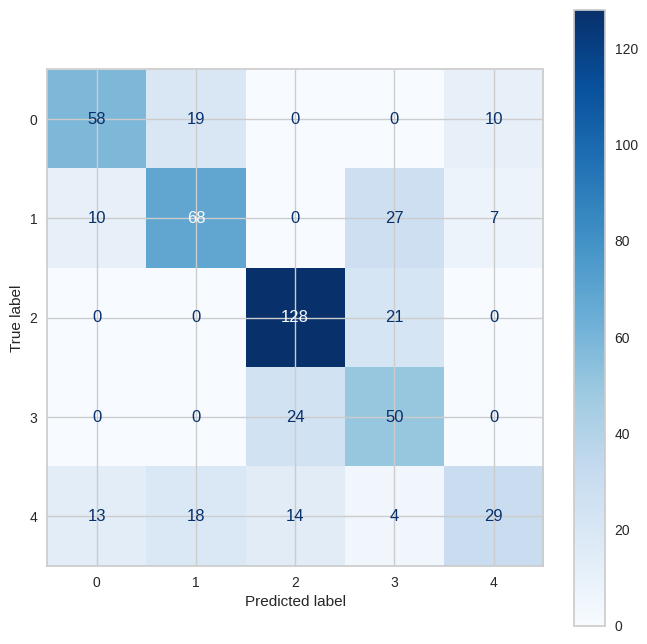

In [13]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test_std, Y_test, cmap="Blues", display_labels = [str(x) for x in sorted(Y_test.unique())], ax = plt.subplot());

Vemos que la clase con mejor rendimiento es la 2 mientras que la peor es la 4.

## c)
### El discriminante lineal asume que las variables son gausianas, pero claramente no es cierto. Quita las variables realmente continuas del conjunto de datos y ajusta un modelo Naïve Bayes. Evalúa adecuadamente la calidad del modelo. Compáralo con el anterior.

In [14]:
# variables realmente continuas (obtenidas al principio) -> alamecenadas en la variable numericas
print(f"Variables continuas a eliminar: {numericas}")

X_train_nb = X_train.drop(numericas, axis = 1)
X_test_nb = X_test.drop(numericas, axis = 1)

nb_model = CategoricalNB() # nuestras variables son categóricas
nb_model.fit(X_train_nb, Y_train)

nb_cv_score = np.mean(cross_val_score(nb_model, X_train_nb, Y_train, cv = 10))
nb_model.best_score_ = nb_cv_score
print(f'Naïve Bayes CV Score: {nb_cv_score:.4f}')

Variables continuas a eliminar: ['A.4', 'F.1']
Naïve Bayes CV Score: 0.6685


Vemos un resultado muy similar a LDA.

In [15]:
print('\nPriors (probabilidades a priori):')
priors_df = pd.DataFrame({
    'Clase': nb_model.classes_,
    'Prior': np.exp(nb_model.class_log_prior_)
})
print(priors_df)

# Probabilidades condicionales CORREGIDO
print('\nProbabilidades condicionales por variable:')
for feature_idx, feature_name in enumerate(X_train_nb.columns):
    # feature_log_prob_ shape: (n_clases, n_características, n_categorías)
    # Para CategoricalNB, necesitamos acceder correctamente
    probs = np.exp(nb_model.feature_log_prob_[feature_idx])
    
    # Crear DataFrame más legible
    df_probs = pd.DataFrame(
        probs,
        index=[f'Clase {cls}' for cls in nb_model.classes_],
        columns=[f'Cat_{j}' for j in range(probs.shape[1])]
    )
    print(f"\n--- Variable: {feature_name} ---")
    print(df_probs.round(4))


Priors (probabilidades a priori):
   Clase   Prior
0      0  0.1735
1      1  0.2255
2      2  0.2985
3      3  0.1475
4      4  0.1550

Probabilidades condicionales por variable:

--- Variable: B.2.2 ---
          Cat_0   Cat_1   Cat_2   Cat_3
Clase 0  0.1966  0.2821  0.3960  0.1254
Clase 1  0.2396  0.3451  0.3407  0.0747
Clase 2  0.1181  0.1764  0.5175  0.1880
Clase 3  0.2007  0.3946  0.3645  0.0401
Clase 4  0.1879  0.3885  0.3662  0.0573

--- Variable: B.3.2 ---
          Cat_0   Cat_1   Cat_2
Clase 0  0.3657  0.4571  0.1771
Clase 1  0.5110  0.3568  0.1322
Clase 2  0.1733  0.4717  0.3550
Clase 3  0.4799  0.4765  0.0436
Clase 4  0.2939  0.6006  0.1054

--- Variable: B.4 ---
          Cat_0   Cat_1   Cat_2   Cat_3   Cat_4   Cat_5
Clase 0  0.5921  0.1785  0.0652  0.0425  0.0312  0.0907
Clase 1  0.5580  0.1247  0.1072  0.0394  0.0481  0.1225
Clase 2  0.6169  0.1575  0.0846  0.0614  0.0182  0.0614
Clase 3  0.6179  0.1495  0.0897  0.0465  0.0399  0.0565
Clase 4  0.5918  0.1709  0.0854  0

La part de priors ja la hem comentat abans.

Podem veure que hi ha algunes variables que tenen més relació amb la classe output que altres.

In [16]:
print(classification_report(Y_test, nb_model.predict(X_test_nb), target_names = [str(x) for x in sorted(Y_test.unique())]))
results_df = save_results(nb_model, X_test_nb, Y_test, 'Naive Bayes', results_df)

              precision    recall  f1-score   support

           0       0.78      0.56      0.65        87
           1       0.57      0.82      0.67       112
           2       0.78      0.65      0.71       149
           3       0.56      0.46      0.50        74
           4       0.51      0.58      0.54        78

    accuracy                           0.63       500
   macro avg       0.64      0.61      0.62       500
weighted avg       0.66      0.63      0.63       500



Vemos que la **accuracy global** es del 63% i el **F1-score** macro del 62%, así que es un modelo bastante similar al LDA probado antes. Hay dos clases con mayor rendimiento que el resto: las clases 0 y 2, mientras que ahora las que destacan por tener menor rendimiento son las classes 3 y 4. Vemos también desbalanceo entre el rendimiento de cada clase.

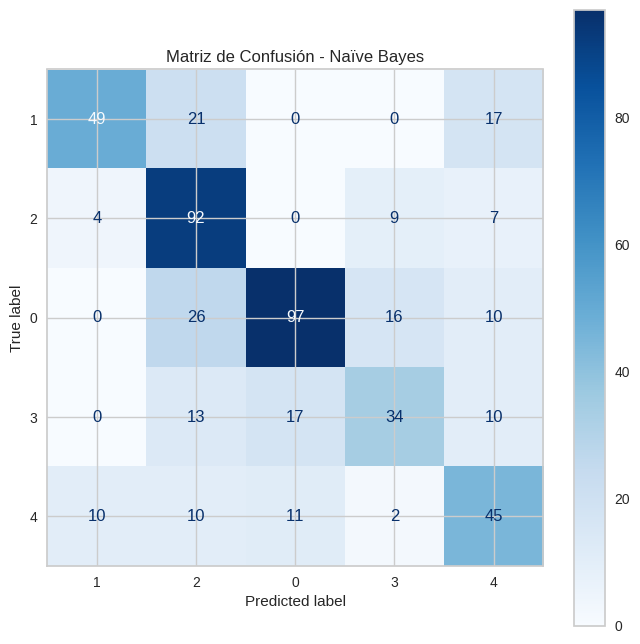

In [17]:
plt.figure(figsize = (8, 8))
ConfusionMatrixDisplay.from_estimator(nb_model, X_test_nb, Y_test, cmap = "Blues", display_labels=[str(x) for x in Y_test.unique()], ax = plt.subplot())
plt.title('Matriz de Confusión - Naïve Bayes')
plt.show()

Vemos lo que acabamos de comentar con el classification report.

## d)
### La regresión logística no asume nada sobre la distribución de las variables, ajusta este modelo a los datos completos. Evalúa adecuadamente la calidad del modelo. Representa los pesos del modelo como un mapa de calor. Compáralos con los que has obtenido para el discriminante lineal. ¿Hay diferencias respecto a las variables que los modelos consideran más importantes?

La implementación de scikit-learn de la regresión logística nos permite aplicar regularización igual que en regresión lineal, podemos utilizar una penalización de los pesos usando L1 o L2.
Podemos hacer una exploración en rejilla para optimizar estos dos hiperparámetros. 

Cuando tenemos mas de un hiperparámetro tenemos un numero combinatorio de posibilidades, lo que requiere una estrategia de exploración para poder probar un numero razonable de posibilidades sin caer en una explosion combinatoria. Para un conjunto de posibilidades podemos ser exhaustivos (Grid Search), pero podemos hacer también una exploración aleatoria (Random Search) o usar estrategias mas sofisticadas como veremos en otros modelos con mas hiperparametros.

En este caso el paralelizar la busqueda es crucial (el parametro n_jobs=-1 indica usar todos los cores de la maquina).

In [18]:
lr = LogisticRegression(max_iter = 3000, solver = 'saga', random_state = 22) # el solver default (lbfgs) no soporta penalización l1. Para usar penalización l1 y l2 en clasificación multiclase usamos el solver saga
param = {'penalty':['l1', 'l2'], 'C': 10**np.linspace(-3, 3, 21, endpoint = True)}
lr_gs =  GridSearchCV(lr, param, cv = 10, n_jobs = -1, refit = True)
lr_gs.fit(X_train, Y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
22,"{'C': 1.9952623149688788, 'penalty': 'l1'}",0.7255,1
41,"{'C': 1000.0, 'penalty': 'l2'}",0.7225,2
37,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.7225,2
38,"{'C': 501.18723362727246, 'penalty': 'l1'}",0.7225,2
36,"{'C': 251.18864315095772, 'penalty': 'l1'}",0.7225,2


Coefs:


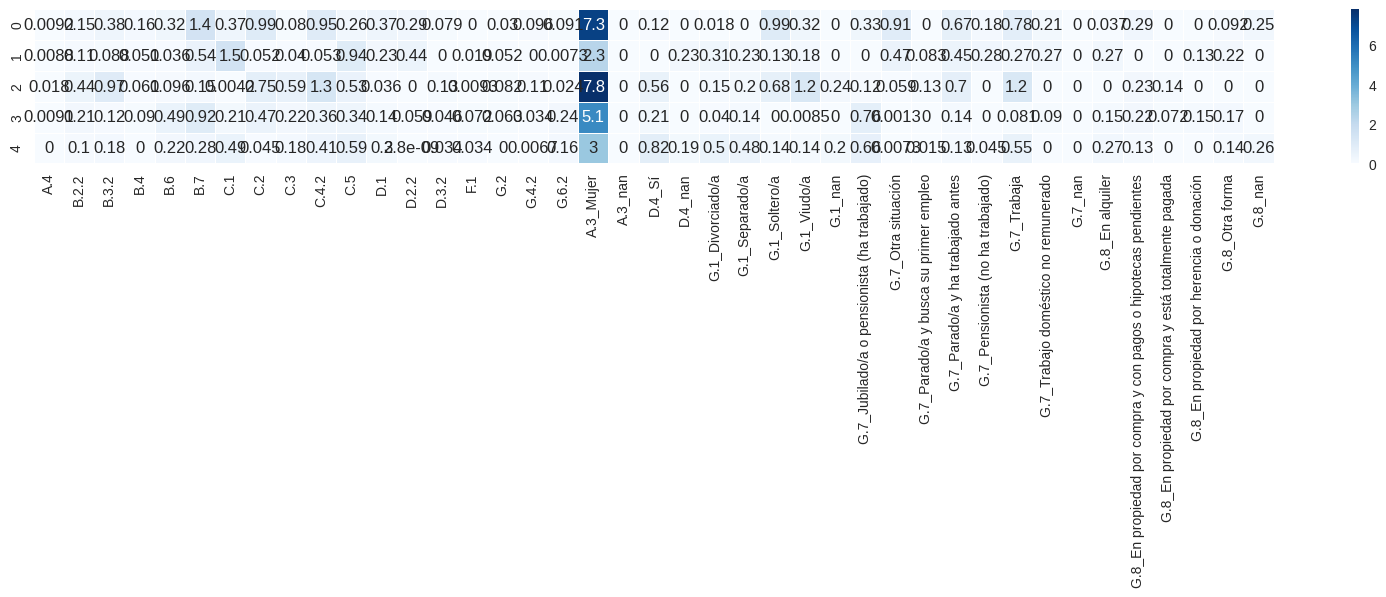

In [19]:
print('Coefs:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns

plt.figure(figsize = (20, 2));
sns.heatmap(coefs.abs(), annot = True, linewidths = .5, cbar = True, xticklabels = True, cmap = 'Blues', annot_kws = {'size': 12});

Podemos ver que los pesos no tienen nada que ver con los pesos de LDA. Tampoco coinciden los atributos con mayor importancia en ambos modelos.

In [20]:
print(classification_report(Y_test, lr_gs.predict(X_test), target_names = [str(x) for x in Y_test.unique()]))
results_df = save_results(lr_gs, X_test, Y_test, 'Logistic', results_df)

              precision    recall  f1-score   support

           1       0.67      0.64      0.65        87
           2       0.66      0.73      0.69       112
           0       0.81      0.81      0.81       149
           3       0.59      0.59      0.59        74
           4       0.59      0.50      0.54        78

    accuracy                           0.68       500
   macro avg       0.66      0.66      0.66       500
weighted avg       0.68      0.68      0.68       500



Estos son los mejores resultados, hemos aumentado la precisión y la recuperación especificamente en la clase que nos interesa y el acierto también ha aumentado

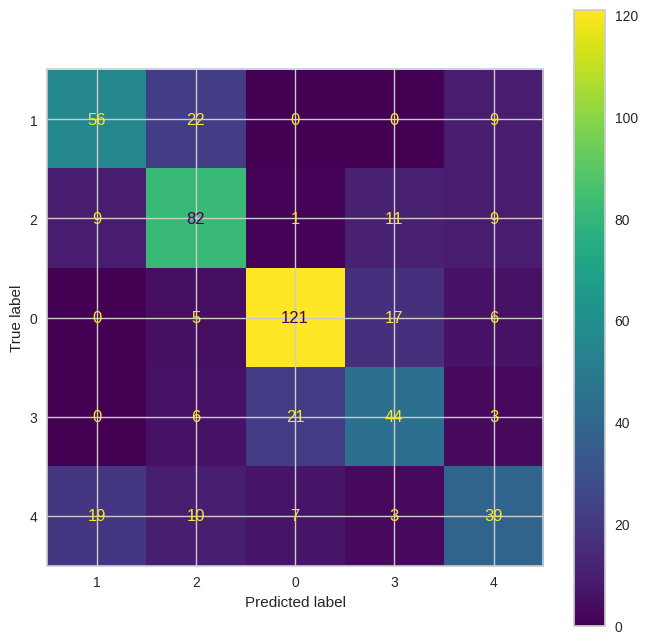

In [22]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, Y_test, display_labels = [str(x) for x in Y_test.unique()], ax = plt.subplot());

Vemos los mismos resultados que los que acabamos de obtener.

=== COMPARACIÓN FINAL DE MODELOS ===
Resumen de comparación de modelos (ordenado por Validación Cruzada):
     Modelo  CV Score  Test Score  Precision (M)  Recall (M)   F1 (M)  Diferencia
   Logistic    0.7255       0.684       0.661382    0.656499 0.657718     -0.0415
Naive Bayes    0.6685       0.634       0.636935    0.614407 0.615104     -0.0345
        LDA       NaN       0.666       0.651077    0.636068 0.633165         NaN
=== ANÁLISIS DE CONSISTENCIA ===


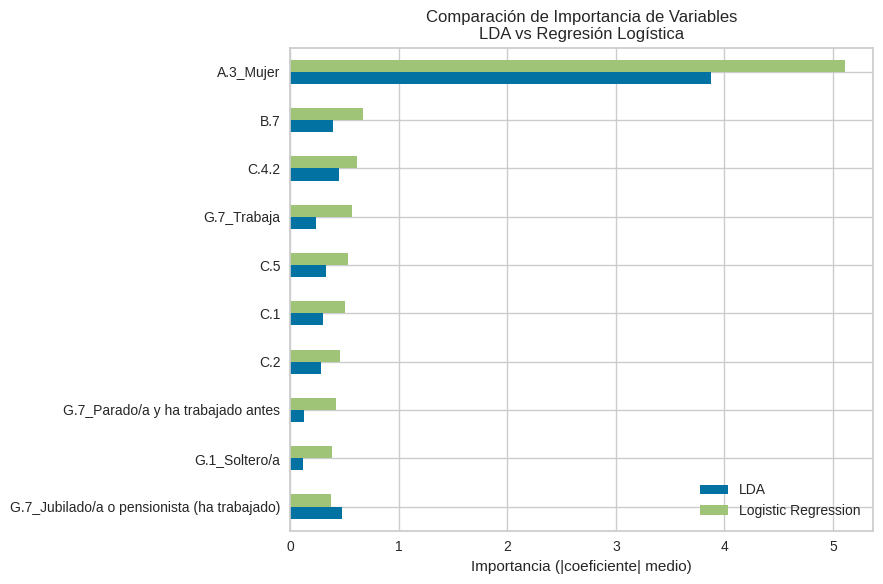

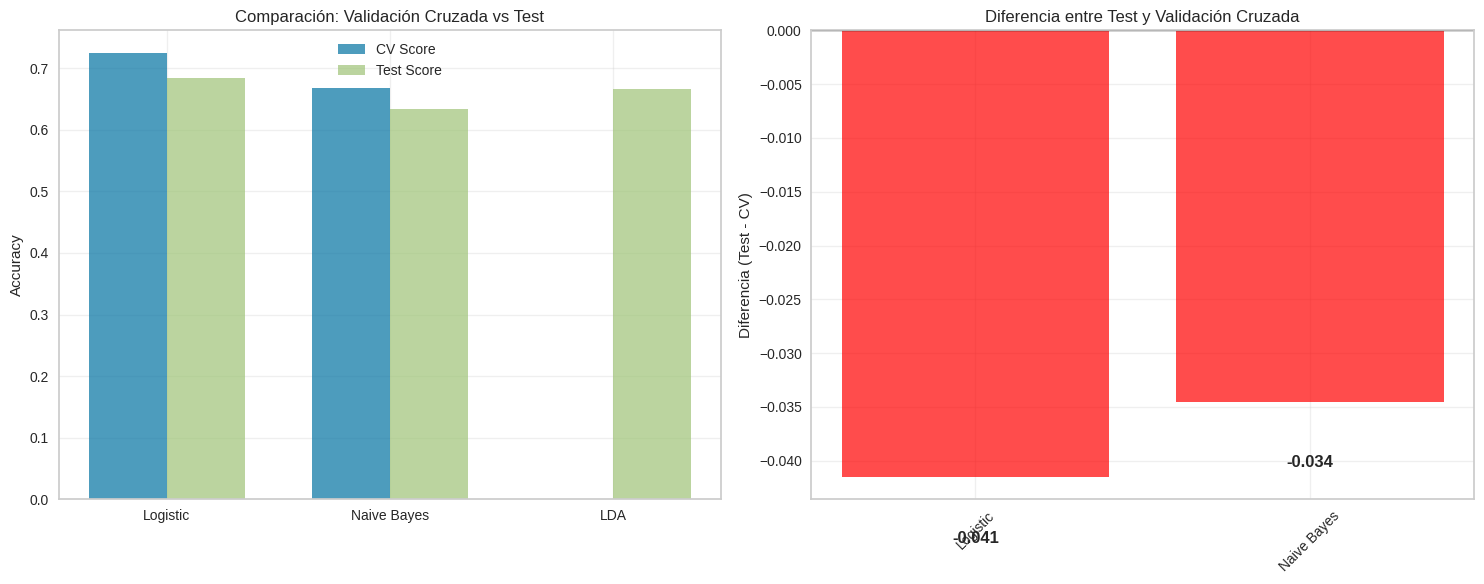


ANÁLISIS DETALLADO POR MÉTRICA


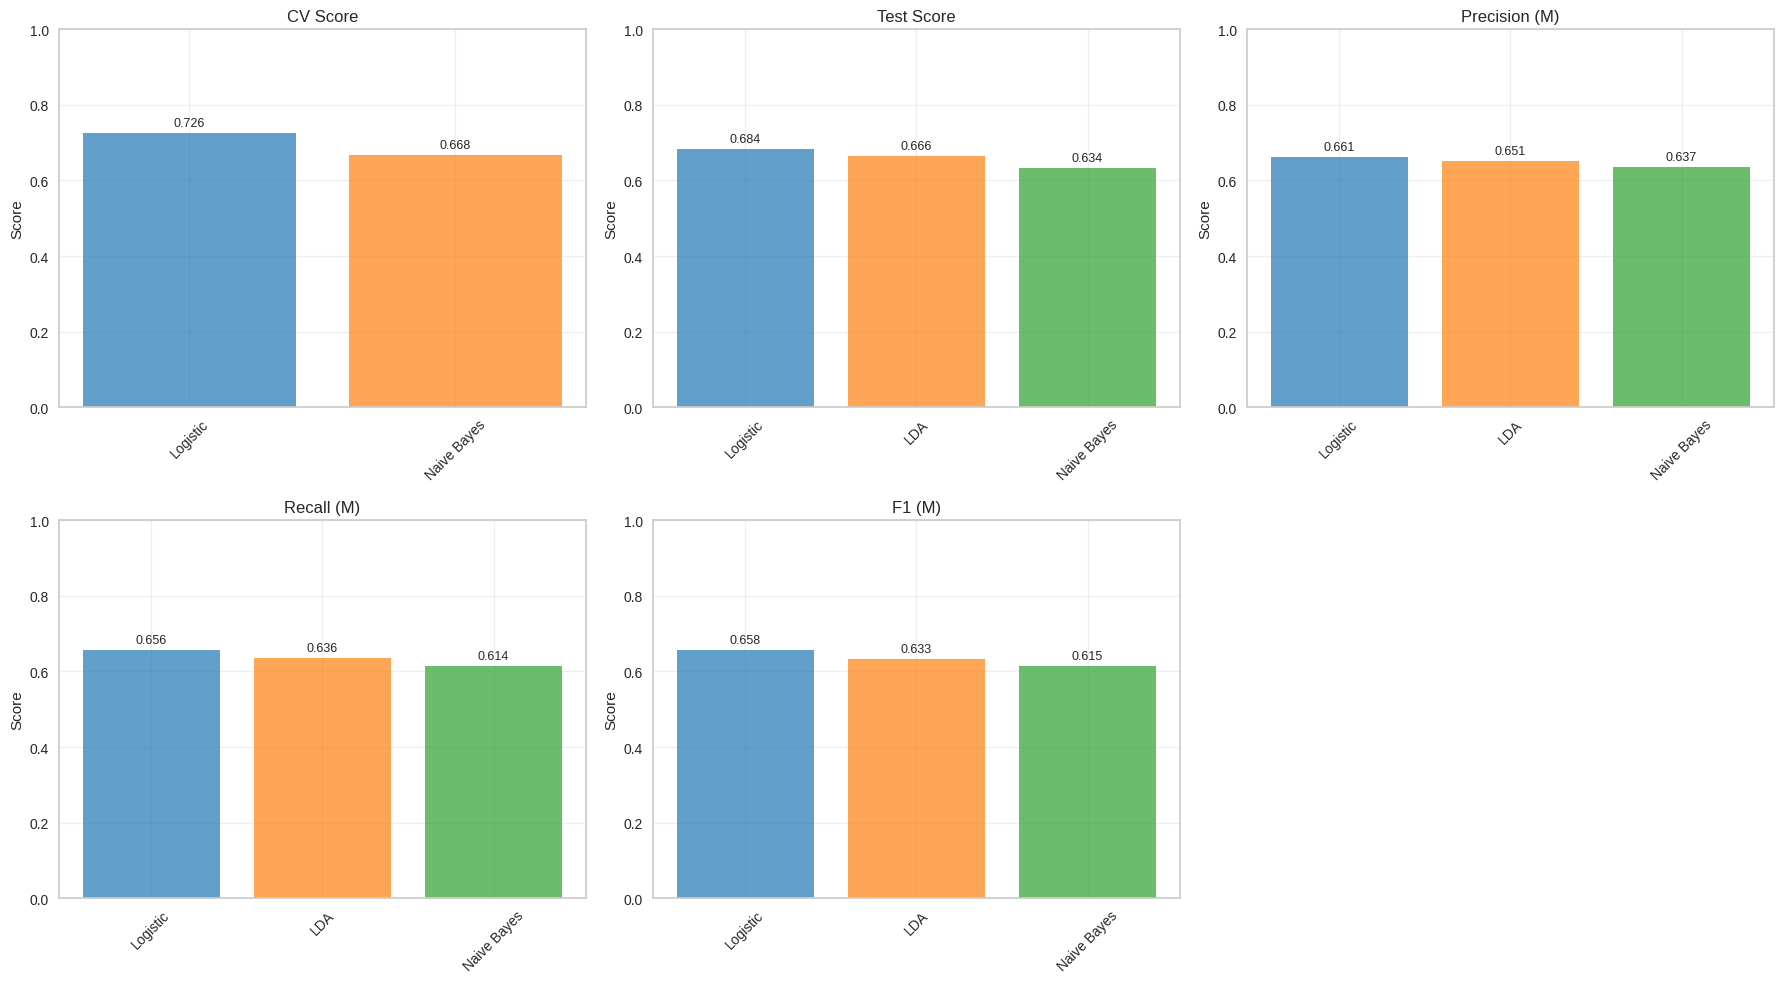


RESUMEN EJECUTIVO
🏆 MEJOR MODELO EN VALIDACIÓN CRUZADA: Logistic
   - Score CV: 0.7255
   - Score Test: 0.6840
   - F1-Score: 0.6577

📈 MEJOR MODELO EN TEST: Logistic
   - Score Test: 0.6840

⚖️  MODELO MÁS CONSISTENTE: Naive Bayes
   - Diferencia CV-Test: -0.0345

✅ RECOMENDACIÓN: Usar Logistic - Es el mejor en CV y Test

🔍 ANÁLISIS DE OVERFITTING:
   Logistic: ✅ CONSISTENTE (diff: -0.0415)
   Naive Bayes: ✅ CONSISTENTE (diff: -0.0345)
   LDA: 🎯 GENERALIZA BIEN (diff: nan)


In [31]:
# Comparación de importancias LDA vs Logistic Regression
# Calcular importancias
lda_importance = pd.Series(np.abs(lda_model.coef_).mean(axis=0), index=X_train.columns)
lr_importance = pd.Series(np.abs(lr_gs.best_estimator_.coef_).mean(axis=0), index=X_train.columns)

# Seleccionar las top 10 características de Logistic Regression para comparar
lr_top_features = lr_importance.sort_values(ascending=False).head(10).index

# Comparación de importancias LDA vs Logistic Regression
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
comparison_importance_df = pd.DataFrame({
    'LDA': lda_importance[lr_top_features],
    'Logistic Regression': lr_importance[lr_top_features]
})
comparison_importance_df.sort_values('Logistic Regression').plot(kind='barh', ax=plt.gca())
plt.title('Comparación de Importancia de Variables\nLDA vs Regresión Logística')
plt.xlabel('Importancia (|coeficiente| medio)')
plt.tight_layout()

# ---- CELL ----
# Comparación final de modelos usando results_df
print("=== COMPARACIÓN FINAL DE MODELOS ===")

# Crear DataFrame de comparación desde results_df
models_comparison = []

for model_name in results_df.index:
    models_comparison.append({
        'Modelo': model_name,
        'CV Score': results_df.loc[model_name, 'train XV acc'],
        'Test Score': results_df.loc[model_name, 'test acc'],
        'Precision (M)': results_df.loc[model_name, 'precision score (M)'],
        'Recall (M)': results_df.loc[model_name, 'recall score (M)'],
        'F1 (M)': results_df.loc[model_name, 'f1 score (M)'],
        'Diferencia': results_df.loc[model_name, 'test acc'] - results_df.loc[model_name, 'train XV acc']
    })

comparison_df = pd.DataFrame(models_comparison)
comparison_df = comparison_df.sort_values('CV Score', ascending=False)

print("Resumen de comparación de modelos (ordenado por Validación Cruzada):")
print(comparison_df.to_string(index=False))

# ---- CELL ----
# Análisis de consistencia y sobreajuste
print("=== ANÁLISIS DE CONSISTENCIA ===")

plt.figure(figsize=(15, 6))

# Gráfico de comparación de scores
plt.subplot(1, 2, 1)
x_pos = np.arange(len(comparison_df))
width = 0.35

plt.bar(x_pos - width/2, comparison_df['CV Score'], width, label='CV Score', alpha=0.7)
plt.bar(x_pos + width/2, comparison_df['Test Score'], width, label='Test Score', alpha=0.7)
plt.xticks(x_pos, comparison_df['Modelo'])
plt.ylabel('Accuracy')
plt.title('Comparación: Validación Cruzada vs Test')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico de diferencias
plt.subplot(1, 2, 2)
colors = ['green' if diff >= 0 else 'red' for diff in comparison_df['Diferencia']]
bars = plt.bar(comparison_df['Modelo'], comparison_df['Diferencia'], color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
plt.ylabel('Diferencia (Test - CV)')
plt.title('Diferencia entre Test y Validación Cruzada')

# Añadir valores en las barras
for bar, diff in zip(bars, comparison_df['Diferencia']):
    plt.text(bar.get_x() + bar.get_width()/2., 
             bar.get_height() + (0.005 if diff >=0 else -0.005),
             f'{diff:.3f}', 
             ha='center', 
             va='bottom' if diff >=0 else 'top',
             fontweight='bold')

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Análisis detallado de rendimiento por métrica
print("\n" + "="*60)
print("ANÁLISIS DETALLADO POR MÉTRICA")
print("="*60)

# Crear gráfico de radar para comparación multidimensional
metrics = ['CV Score', 'Test Score', 'Precision (M)', 'Recall (M)', 'F1 (M)']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    ax = axes[i]
    sorted_data = comparison_df.sort_values(metric, ascending=False)
    bars = ax.bar(sorted_data['Modelo'], sorted_data[metric], 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(sorted_data)], alpha=0.7)
    ax.set_title(f'{metric}')
    ax.set_ylabel('Score')
    ax.tick_params(axis='x', rotation=45)
    
    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

# Ocultar ejes sobrantes
for i in range(len(metrics), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Resumen ejecutivo
print("\n" + "="*60)
print("RESUMEN EJECUTIVO")
print("="*60)

best_overall = comparison_df.iloc[0]
best_test = comparison_df.loc[comparison_df['Test Score'].idxmax()]
best_consistent = comparison_df.loc[comparison_df['Diferencia'].abs().idxmin()]

print(f"🏆 MEJOR MODELO EN VALIDACIÓN CRUZADA: {best_overall['Modelo']}")
print(f"   - Score CV: {best_overall['CV Score']:.4f}")
print(f"   - Score Test: {best_overall['Test Score']:.4f}")
print(f"   - F1-Score: {best_overall['F1 (M)']:.4f}")

print(f"\n📈 MEJOR MODELO EN TEST: {best_test['Modelo']}")
print(f"   - Score Test: {best_test['Test Score']:.4f}")

print(f"\n⚖️  MODELO MÁS CONSISTENTE: {best_consistent['Modelo']}")
print(f"   - Diferencia CV-Test: {best_consistent['Diferencia']:.4f}")

# Recomendación final
if best_overall['Modelo'] == best_test['Modelo']:
    print(f"\n✅ RECOMENDACIÓN: Usar {best_overall['Modelo']} - Es el mejor en CV y Test")
else:
    print(f"\n🤔 RECOMENDACIÓN: Considerar trade-off entre {best_overall['Modelo']} (mejor CV) y {best_test['Modelo']} (mejor Test)")

# Análisis de overfitting/underfitting
print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
for _, row in comparison_df.iterrows():
    status = "✅ CONSISTENTE" if abs(row['Diferencia']) < 0.05 else \
             "⚠️  POSIBLE OVERFITTING" if row['Diferencia'] < -0.05 else \
             "🎯 GENERALIZA BIEN"
    print(f"   {row['Modelo']}: {status} (diff: {row['Diferencia']:.4f})")